In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [6]:
#change below path to /tf/username/model_img/ALL
PATH = '/raid/arnold/clouds_detection/ESSX'
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

#set batch size and original image dimensions
batch_size = 32
img_height = 720
img_width = 1280

#total image count
print(image_count)

4172


(720, 1080, 3)


array([[[ 77, 132, 197],
        [ 77, 132, 197],
        [ 77, 132, 197],
        [ 75, 133, 197]],

       [[ 77, 132, 197],
        [ 77, 132, 197],
        [ 77, 132, 197],
        [ 75, 133, 197]],

       [[ 77, 132, 197],
        [ 77, 132, 197],
        [ 77, 132, 197],
        [ 75, 133, 197]],

       [[ 77, 132, 197],
        [ 77, 132, 197],
        [ 77, 132, 197],
        [ 75, 133, 197]]], dtype=uint8)

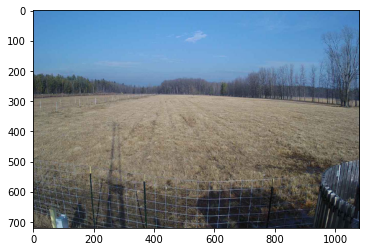

In [8]:
#do a quick check and make sure you have image data
files = os.listdir(f'{PATH}/clear')[:10]
img = plt.imread(f'{PATH}/clear/{files[9]}')
plt.imshow(img);
print(img.shape)
# First 4 rows and columns of the image
img[:4,:4]

In [ ]:
#if using croping uncomment this section and comment out below code where i indicated
# #cropping top of image 
# height, width, channels = img.shape
# print(int(height/3))
# croppedImage = img[0:int(height/3), 0:width] #this line crops
# # croppedImage = img[0:360, 0:width] #this line crops

# plt.imshow(croppedImage);
# croppedImage.shape

In [ ]:
# #cropping center
# image = tf.image.resize_with_crop_or_pad(img, 240, 1280) 
# image = tf.image.random_crop(image, size=[240, 1280, 3])
# plt.imshow(image);
# image.shape
# # Random crop back to the original size
# #   image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])

In [ ]:
# input_shape = (1,720, 1280, 3)
# print(input_shape)
# x = np.arange(np.prod(input_shape)).reshape(input_shape)
# y = tf.keras.layers.Cropping2D(cropping=((2, 2), (4, 4)))(x)
# print(y.shape)

In [ ]:
# #WORKS to crop multi images now need to save them for a model

# folder_path = '/home/mesonet/cam_photos/2018/08/17/ESSX'
# from keras.preprocessing import image

# # load all images into a list
# paths = []
# images = []
# for img in os.listdir(folder_path):
#     img = os.path.join(folder_path, img)
#     paths.append(img)
#     img = image.load_img(img, target_size=(img_height, img_width))
#     img = image.img_to_array(img)
#     img = img[0:int(height/3), 0:width]
#     img = np.expand_dims(img, axis=0)
#     images.append(img)
# # print(images[1])
# # stack up images list to pass for prediction
# images = np.vstack(images)

# #print(paths[-1])
# #PIL.Image.open(paths[-1])
# plt.figure(figsize=(10, 10))
# for i in range(15):
#     ax = plt.subplot(5, 3, i + 1)
#     plt.imshow(images[i].astype("uint8"))
#     plt.axis("off")

In [9]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [ ]:
#run rm -rf .ipynb_checkpoints to get correct class names

In [ ]:
#below if not cropping

In [10]:
#look under fine tune in https://www.tensorflow.org/tutorials/load_data/images to add cropping into pipeline myself
#take 80% for training and pass 20% in next cell for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4172 files belonging to 4 classes.
Using 3338 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4172 files belonging to 4 classes.
Using 834 files for validation.


In [ ]:
# #use this manual method if cropping being applied or above if not cropping
# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
# for f in list_ds.take(5):
#   print(f.numpy())

# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)
# #split into training and val 
# val_size = int(image_count * 0.2)
# train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)

# print(tf.data.experimental.cardinality(train_ds).numpy())
# print(tf.data.experimental.cardinality(val_ds).numpy())


In [ ]:
# def get_label(file_path):
#   # convert the path to a list of path components
#     parts = tf.strings.split(file_path, os.path.sep)
#   # The second to last is the class-directory
#     one_hot = parts[-2] == class_names
#   # Integer encode the label
#     return tf.argmax(one_hot)

# def decode_img(img):
#   # convert the compressed string to a 3D uint8 tensor
#     img = tf.image.decode_jpeg(img, channels=3)
#   # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])


# def process_path(file_path):
#     label = get_label(file_path)
#   # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)
#     img = decode_img(img)
# #     img = image.img_to_array(img)
#     height, width, channels = img.shape
# #     img = img[0:int(height/3), 0:width] #1/3 top 
#     img = img[0:int(height/2), 0:width] #half
#     print(img.shape)
#     return img, label

In [ ]:
# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# for image, label in train_ds.take(1):
#   print("Image shape: ", image.numpy().shape)
#   print("Label: ", label.numpy())

In [ ]:
# def configure_for_performance(ds):
#     ds = ds.cache()
#     ds = ds.shuffle(buffer_size=1000)
#     ds = ds.batch(batch_size)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     return ds

# train_ds = configure_for_performance(train_ds)
# val_ds = configure_for_performance(val_ds)

# image_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     label = label_batch[i]
#     plt.title(class_names[label])
#     plt.axis("off")

In [ ]:
# model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=3
# )

In [14]:
#comment out if doing cropping
class_names = train_ds.class_names

In [15]:
#check classs names to make sure you dont have any hidden folders and img dims are correct
print(class_names)
print(train_ds)

['clear', 'night', 'overcast', 'scattered']
<BatchDataset shapes: ((None, 720, 1280, 3), (None,)), types: (tf.float32, tf.int32)>


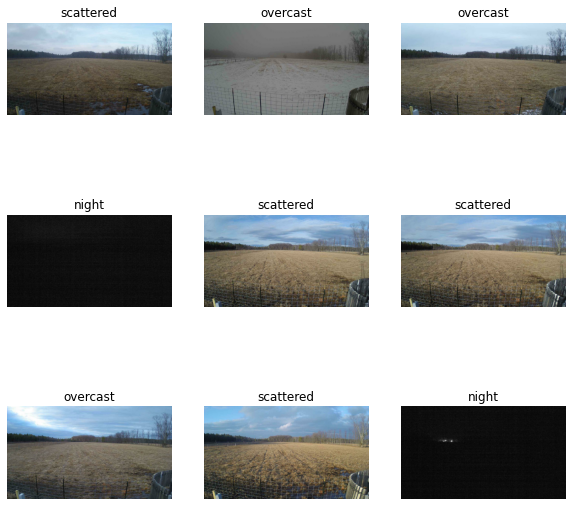

In [16]:
#display a few images for a sanity check (all labels should be correct, and no imgs should be corrupted)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
#tensor of shape (batch size, hgt, width, rgb)
#call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 720, 1280, 3)
(32,)


In [18]:
#NOTE
'''
Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

Dont forget to clear notebook and shut down kernel when done, otherwise gpu memory will not be released
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#RGB channel values are in the [0, 255] range. Bad for neural network; want input values small. 
#Standardize values to be in the [0, 1] by using a Rescaling layer.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [20]:
#apply normalization layer to full dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [21]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [22]:
num_classes = len(class_names) #if you get error you  prob need to delete .ipyn checkpoint
#build the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  #rescale input in the [0, 255] range to be in the [0, 1] range
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
#compile the model (To view training and validation accuracy for each training epoch, pass the metrics argument)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
#View all the layers of the network using the model's summary method:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 720, 1280, 3)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 720, 1280, 16)     448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 360, 640, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 640, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 320, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 320, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 160, 64)       0

In [25]:
#train the model
epochs=2 #if you want to do quick test run change this to 1 or 2
history = model.fit(
  normalized_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

Epoch 1/2
105/105 [==============================] - 98s 857ms/step - loss: 0.9588 - accuracy: 0.5361 - val_loss: 0.6161 - val_accuracy: 0.7734
Epoch 2/2
105/105 [==============================] - 80s 764ms/step - loss: 0.6063 - accuracy: 0.7499 - val_loss: 0.4392 - val_accuracy: 0.8465


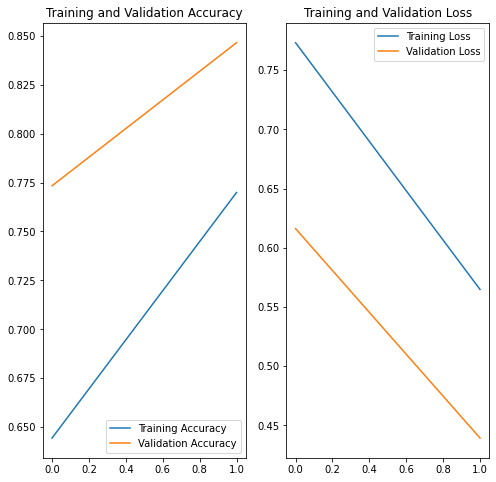

In [26]:
'''
NOTE
if training accuracy and validation accuracy are off by large margin then need to tune the model and its overfitting
overfitting if diiff in acc between training and val accuracy is noticeable
also if training acc inc linearly but val acc stalls around 50-60%

FIX:
'When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training sometimes referred to as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to stop overfitting in the training process. We will use two differnet ways below. First by creating more images using data augmentation and second adding a Dropout layer to the model.'
'''
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
# #save the model
# model.save("/raid/arnold/clouds_detection/model/custom_cloud_classification/")

In [ ]:
#load model
# It can be used to reconstruct the model identically and i am going to load this model i ran overnight to save time.
# model = keras.models.load_model("/raid/arnold/clouds_detection/model/custom_cloud_classification/")

In [28]:
#Data augmentation - generating additional training data from your existing examples by augmenting then using transformations that yield believable-looking images
#below i have examples of random cropping, flipping, rotations and zoom. 
data_augmentation = keras.Sequential(
  [
#       tf.keras.layers.experimental.preprocessing.RandomCrop(
#     240, 1280
# )
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [29]:
# data_augmentation(images)

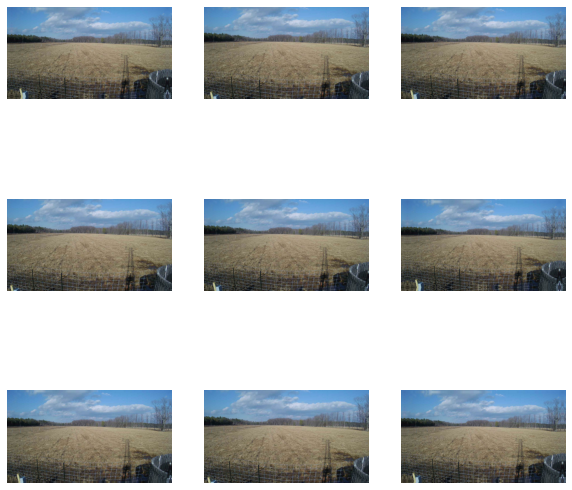

In [44]:
#viz some of the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [31]:
#Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.
print(len(class_names))
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

4


In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [35]:
# model.summary()

In [38]:
epochs = 10
history = model.fit(
  normalized_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

Epoch 1/10
105/105 [==============================] - 76s 731ms/step - loss: 0.6054 - accuracy: 0.7507 - val_loss: 0.5609 - val_accuracy: 0.7566
Epoch 2/10
105/105 [==============================] - 76s 721ms/step - loss: 0.5255 - accuracy: 0.7849 - val_loss: 0.5354 - val_accuracy: 0.7854
Epoch 3/10
105/105 [==============================] - 76s 726ms/step - loss: 0.4591 - accuracy: 0.8098 - val_loss: 0.3997 - val_accuracy: 0.8177
Epoch 4/10
105/105 [==============================] - 76s 726ms/step - loss: 0.4155 - accuracy: 0.8250 - val_loss: 0.4676 - val_accuracy: 0.7938
Epoch 5/10
105/105 [==============================] - 76s 730ms/step - loss: 0.3678 - accuracy: 0.8442 - val_loss: 0.3234 - val_accuracy: 0.8561
Epoch 6/10
105/105 [==============================] - 75s 714ms/step - loss: 0.3319 - accuracy: 0.8604 - val_loss: 0.3116 - val_accuracy: 0.8741
Epoch 7/10
105/105 [==============================] - 76s 724ms/step - loss: 0.3126 - accuracy: 0.8730 - val_loss: 0.2821 - val_ac

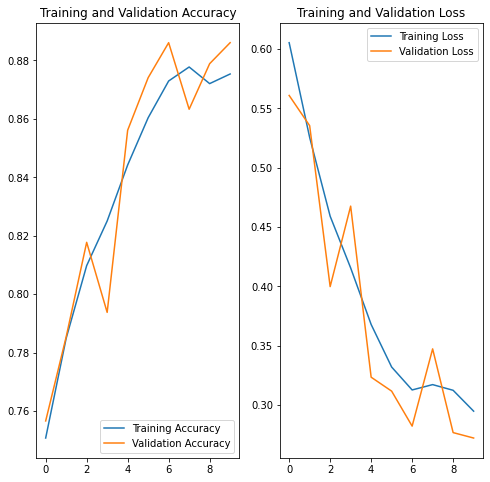

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[-347.89514 -338.8374   820.99567  833.3901 ]]
This image most likely belongs to scattered with a 100.00 percent confidence.


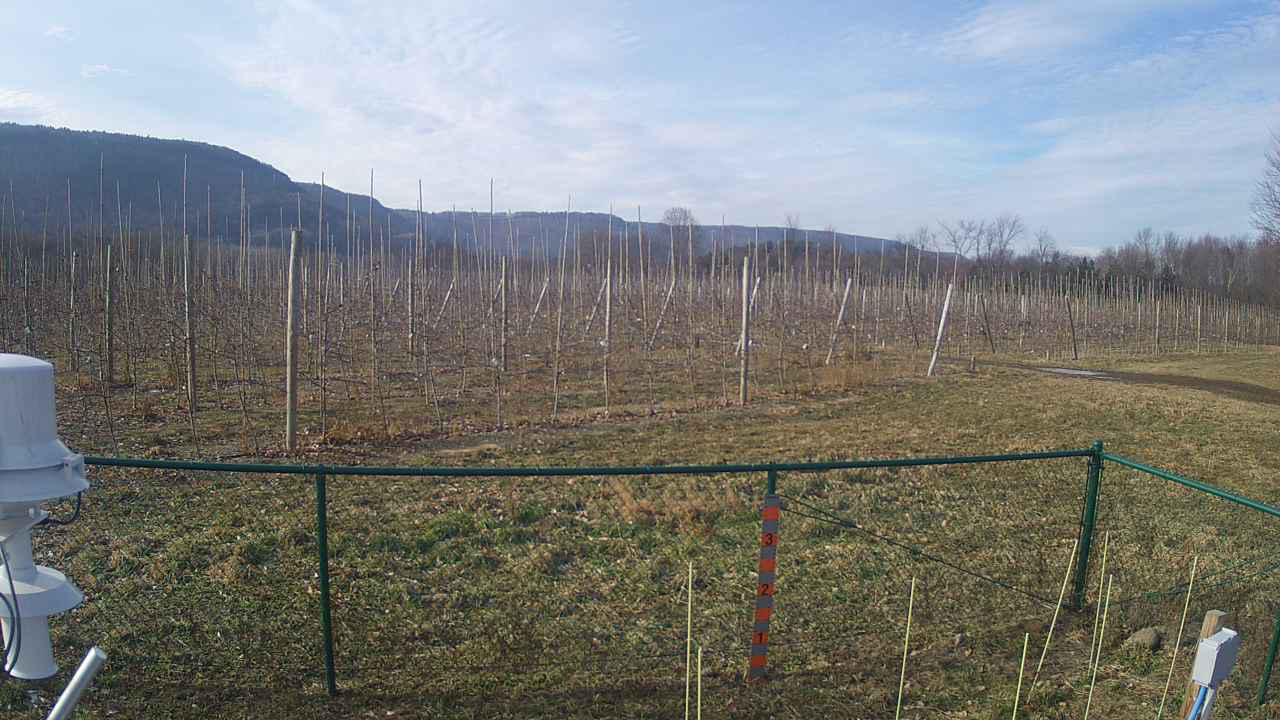

In [27]:
new_img_path =  '/raid/mesonet/cam_photos/2018/12/20/VOOR/20181220T175030_VOOR.jpg'
#new_img_path = '/home/arnold/raindrop-detection-cnn/mesonet/20161013T164513_YORK.jpg_sliding_window.jpg'

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [ ]:
#uncomment to save augmented model
# model.save("/raid/arnold/clouds_detection/models/custom_cloud_classification_augmented_3_sites")

In [ ]:
#load model
# It can be used to reconstruct the model identically and i am going to load this model i ran overnight to save time.
# model = keras.models.load_model("/raid/arnold/clouds_detection/models/custom_cloud_classification_augmented_3_sites")

In [40]:
tf_model_predictions = model.predict(images)

In [41]:
print(tf_model_predictions.shape) #“Prediction results shape:”, (219, 7)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
# predicted_labels = class_names[predicted_ids]
print(predicted_ids)

(32, 4)
[3 3 3 3 2 3 2 3 2 2 3 3 3 2 3 3 3 3 3 2 2 2 3 3 3 3 3 2 3 3 2 3]
